First part of this notebook will cover the exploration of how to set-up an NLP agent, as I will first require some more base knowledge before starting on my own novel agent.  
I will be following [this blogpost](https://linuxhint.com/getting-started-agents-langchain/).  
As a pre-requisite: langchain will have to be installed (pip install langchain)

I will be using the openAI API for which an API key is required (so create an openAI account->API keys->create new secret key).  
It is also explained step-by-step [here](https://linuxhint.com/set-up-environment-langchain/)

Here an input field will be opened where the API secret can be set into the current environment for later use

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

Create the model using lanchain's OpenAI

In [2]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature=0)

Setup a tool that the model can use, in this case a tool that simply returns the length of the word

In [3]:
from langchain.agents import tool

@tool

def get_word_length(word: str) -> int:

   """getting the word's length"""

   return len(word)

tools = [get_word_length]

idk what this does lol

In [4]:
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([

  ("system", "your assistant is quite amazing, but need improvement at calculating lengths"),

  ("user", "{input}"),

  MessagesPlaceholder(variable_name="agent_scratchpad"),

])

Bind the tools to the model

In [5]:
from langchain.tools.render import format_tool_to_openai_function

llm_with_tools = llm.bind(

  functions=[format_tool_to_openai_function(t) for t in tools]

)

idk what this does either

In [6]:
from langchain.agents.format_scratchpad import format_to_openai_functions

from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

agent = {

   "input": lambda x: x["input"],

   "agent_scratchpad": lambda x: format_to_openai_functions(x['intermediate_steps'])

} | prompt | llm_with_tools | OpenAIFunctionsAgentOutputParser()

idk this either

In [7]:
agent.invoke({

  "input": "how many letters in the word good",

  "intermediate_steps": []

})

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

As you can see however, I actually can not invoke this model, as my free openAI account does not have sufficient funds

According to [this forum post](https://community.openai.com/t/openai-api-keys-in-free-account/348972/2), a free OpenAI account gets trial funds that last are only available for the first 3 months of an account, and because I have been using my OpenAI account since the open trial phase of Chat GPT, I have created a new fresh account (which was suprisingly fine, as the phone number verification apparently does not check if that number has been used before). 

So lets create a new model with the API key of this fresh account

In [11]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature=0)

from langchain.tools.render import format_tool_to_openai_function

llm_with_tools = llm.bind(
functions=[format_tool_to_openai_function(t) for t in tools]
)

from langchain.agents.format_scratchpad import format_to_openai_functions

from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

agent = {

   "input": lambda x: x["input"],

   "agent_scratchpad": lambda x: format_to_openai_functions(x['intermediate_steps'])

} | prompt | llm_with_tools | OpenAIFunctionsAgentOutputParser()

In [12]:
agent.invoke({

  "input": "how many letters in the word good",

  "intermediate_steps": []

})

AgentActionMessageLog(tool='get_word_length', tool_input={'word': 'good'}, log="\nInvoking: `get_word_length` with `{'word': 'good'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "word": "good"\n}', 'name': 'get_word_length'}})])

So this time it actually succeeded! (atleast to some degree)  

Looking at my API usage, it is also shown that I now have used 0.01$ of my 5$ allowance  
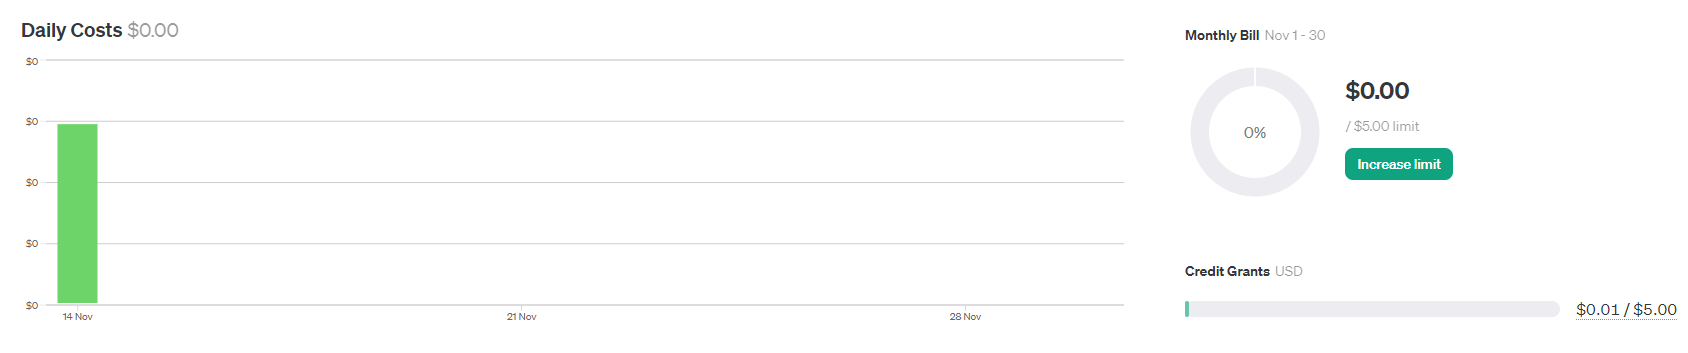  

Which would be fine if it weren't for the fact my other account showed a possible allowance of 18$, but it is sadly expired :'(  
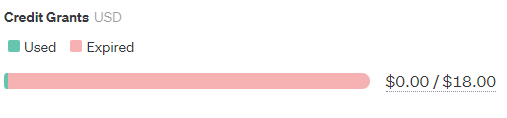

Lets continue with the guide, after this very fun side-track

Lets add the intermediate steps to the model

In [13]:
from langchain.schema.agent import AgentFinish
intermediate_steps = []
while True:
    output = agent.invoke({
        "input": " letters in good",
        "intermediate_steps": intermediate_steps
    })
    if isinstance(output, AgentFinish):
        final_result = output.return_values["output"]
        break
    else:
        print(output.tool, output.tool_input)
        tool = {
            "get_word_length": get_word_length
        }[output.tool]
        observation = tool.run(output.tool_input)
        intermediate_steps.append((output, observation))
print(final_result)

get_word_length {'word': 'good'}
The word "good" has 4 letters.


Cool, I now have a working transformer that can find the word of interest in a sentence, in this case: "letters in good", and it will output the letter count of the word "good". For this I am not actually using a transformer from OpenAI via their API, instead of having to train my own (which would take a while).  
In this first attempt, specifically the OpenAI's Chat model is used, while OpenAI has integrations with other kinds of models aswell with Langchain, just as the more general purpose LLM.

Now that I know the general setup, and integration of OpenAI's models with Langchain, lets set-up a quick chatbot powered by GPT-3.5

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [16]:
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferWindowMemory

template = """Answer the question: {question}, in old english and without ever referring to any technology after the 11th century, 
            keep trying to explain what would have been a modern term with old english things generally not used in the 21st century"""

prompt = PromptTemplate(input_variables=["question"], template=template)

chatgpt_chain = LLMChain(
    llm=ChatOpenAI(model_name = "gpt-3.5-turbo", temperature=0),
    prompt=prompt,
    verbose=True,
    memory=ConversationBufferWindowMemory(k=2)
)

In [17]:
output = chatgpt_chain.predict(
    question="What is a deadlock in programming?"
)
print(output)



> Entering new LLMChain chain...
Prompt after formatting:
Answer the question: What is a deadlock in programming?, in old english and without ever referring to any technology after the 11th century, keep trying to explain what would have been a modern term with old english things generally not used in the 21st century

> Finished chain.
Verily, a deadlock in the realm of programming doth occur when two or more processes or threads becometh entangled in a most perplexing predicament. 'Tis akin to a stalemate, where each entity doth await the other's action, yet neither can proceedeth forth. Like a knight and a dragon, locked in a fierce battle, their swords clashing but neither gaining the upper hand.

In this conundrum, each process doth holdeth a resource that the other requireth to continue its noble quest. Alas, neither can releaseth their hold on the coveted resource, for fear of losing their own progress. Thus, they remaineth locked in an eternal struggle, akin to a mighty tug-o

In [ ]:
print(chatgpt_chain.predict(question="What is a pokemon?"))